# _CSE 546 Reinforcement Learning (Spring 2024)_

## Assignment 1 (Checkpoint 1)

In [1]:
# Imports
import gymnasium
from gymnasium import spaces
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Doordash delivery agent in a deterministic grid environment

class DeterministicGrid:
    
    def __init__(self):
        
        self.observation_space = 16
        self.agent_state = (0,0) # the environment puts the agent here for the first time
        self.old_state_f = 0
        self.new_state_f = 0
        
        # environment
        self.environment = np.zeros((4,4)) 
        self.environment[1, 2] = -1 # police
        self.environment[2, 1] = 1 # free food
        self.environment[0, 3] = 0.5 # free fuel
        self.environment[3, 3] = 50 # home
    
    def reset(self):
        self.environment = np.zeros((4,4))
        self.agent_state = (0,0) 
        self.environment[1, 2] = -1 # police
        self.environment[2, 1] = 1 # free food
        self.environment[0, 3] = 0.5 # free fuel
        self.environment[3, 3] = 50 # home
        self.old_state_f = 0
        self.new_state_f = 0
        
        return self.new_state_f
        
    def step(self, action):
        
        current_state = self.agent_state
        self.old_state_f = (current_state[0]*4) + current_state[1]
        
        terminated = False

        if action == 0:  # UP
            current_state = (current_state[0]-1, current_state[1])
        elif action == 1:  # DOWN
            current_state = (current_state[0]+1,current_state[1])
        elif action == 2:  # LEFT
            current_state = (current_state[0],current_state[1]-1)
        elif action == 3: # RIGHT
            current_state = (current_state[0],current_state[1]+1)
            
        current_state = tuple(np.clip(current_state, 0, 3))
        
        imm_reward = 0
        
        if current_state == (1,2):
            imm_reward = -1  # agent finds the police
        elif current_state == (2,1):
            imm_reward = 1   # agent gets free food
        elif current_state == (0,3):
            imm_reward = 0.5  # agent gets free fuel
        elif current_state == (3,3):
            terminated = True
            imm_reward = 50  # agent delivers the food
            
        self.new_state_f = (current_state[0]*4) + current_state[1]
        
        self.agent_state = current_state
        # step taken by environment returns the immediate reward, agent_state & meta_data
        return imm_reward, self.agent_state, terminated, self.old_state_f, self.new_state_f
    
    def render(self):
        a = "O=o"  # symbol for the agent, a car!
        s = " "
        print("-------------------------------", end="\n")
        for row in range(4):
            for col in range(4):
                if (row, col) == self.agent_state:
                    print(f"|{a:^{5}}|", end=" ")
                elif self.environment[row, col] == 0:
                    print(f"|{s:^{5}}|", end=" ")
                else:
                    print(f"|{self.environment[row, col]:^{5}}|", end=" ")
            print("\n-------------------------------", end="\n")

### Part 2.1  Base Model - Agent in a Deterministic grid environment trained using Q-learning algorithm

In [3]:
class Q_Agent:
    
    def __init__(self, environment, learning_rate, discount_factor):
        self.action_space = 4
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.env = environment
        self.Qtable = np.zeros((environment.observation_space, self.action_space))
    
    def step(self, epsilon):
        rand_num = np.random.random()
        if  epsilon != -1 and rand_num < epsilon:
            return np.random.randint(self.action_space) # explore
        else:
            # exploit
            agent_state = self.env.new_state_f
            return np.argmax(self.Qtable[agent_state,:])
        
    def updateQestimates(self, imm_reward, old_state, new_state, action):
        Qmax = max(self.Qtable[new_state,:])
        self.Qtable[old_state, action] = self.Qtable[old_state, action] + self.learning_rate*(imm_reward + (self.discount_factor*Qmax) - self.Qtable[old_state, action])
        
    def printQtable(self):
        Qdf = pd.DataFrame(self.Qtable)
        Qdf.columns = ["Up", "Down", "Left", "Right"]
        Qdf.index = [f"State {i}" for i in range(16)]
        print(Qdf)
        return Qdf

In [4]:
def train_t(agent, environment, steps, epsilon, flag = True):
    environment.reset()
    reward_history = []
    for i in range(steps):
        action = agent.step(epsilon)
        reward, agent_state, terminated, old_state_f, new_state_f = environment.step(action)
        reward_history.append(reward)
        if flag:
            agent.updateQestimates(reward, old_state_f, new_state_f, action)
        if terminated: break
    return sum(reward_history)

In [5]:
# train_e() is a slight modification of train_t() 

def train_e(agent, environment, steps, epsilon, flag = True):
    reward_history = []
    environment.reset()
    for i in range(steps):
        action = agent.step(epsilon)
        reward, agent_state, terminated, old_state_f, new_state_f = environment.step(action)
        print("action: moved", action_map[action])
        print("new_state:",agent_state)
        print("reward obtained:", reward)
        reward_history.append(reward)
        environment.render()
        if flag:
            agent.updateQestimates(reward, old_state_f, new_state_f, action)
        if terminated: break
    return sum(reward_history)

In [6]:
def show_epsilon_decay(epsilon_array, episodes):
    plt.figure()
    plt.plot(epsilon_array)
    plt.title("Epsilon Decay Graph")
    plt.xlabel("episode")
    plt.ylabel("epsilon value")
    plt.xlim(0,episodes)
    plt.ylim(0,1)
    plt.grid()
    plt.show()

In [7]:
def total_reward_per_episode(total_reward, episodes):
    plt.figure()
    plt.plot(total_reward)
    plt.title('Total reward per episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.xlim(0, 0.75*episodes)
    plt.ylim(-50, 100)
    plt.grid()
    plt.show()

In [8]:
# create environment
environment = DeterministicGrid()

# create agent and place the agent in the evnironment
agent = Q_Agent(environment, discount_factor = 0.98, learning_rate = 0.10)

In [9]:
# set up
episodes = 1100
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [ max(1*(0.9954**i),0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)

In [10]:
# running the Q-learning agent for 10 timesteps
print("Total reward for the episode:", train_e(agent, environment, 10, 5, False))

action: moved down
new_state: (1, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
| O=o | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
| O=o | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved up
new_state: (1, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
| O=o | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     |

Initial Q-table
           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


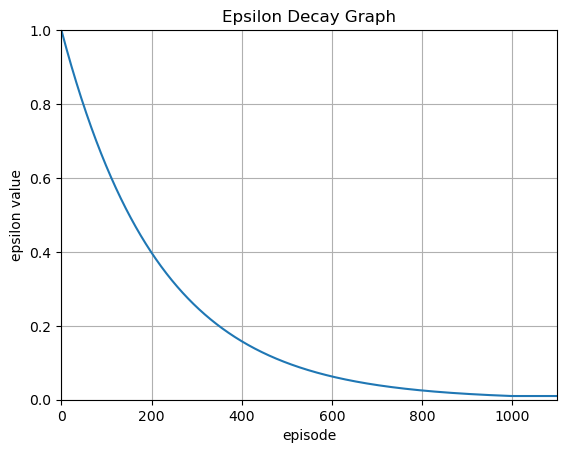

Trained Q-table
                 Up       Down       Left      Right
State 0   44.155751  46.156440  45.053863  44.368234
State 1   13.732809  46.793252  15.661084  12.504668
State 2    4.243722  11.496128   2.220776  23.430661
State 3    8.321717  37.256580   5.698160   9.981872
State 4   43.375905  47.098408  42.842705  46.869702
State 5   30.002949  48.059389  27.547903  28.770443
State 6    5.286533  47.794904   8.341180  19.263696
State 7   17.335992  48.502003  16.099340  11.654275
State 8   44.289960  44.823024  45.957671  48.059600
State 9   46.633119  47.685195  46.473487  48.020000
State 10  43.739370  48.759138  47.724711  49.000000
State 11  43.939032  50.000000  47.091438  48.361505
State 12  27.258474  18.554673  23.305650  47.614720
State 13  36.107266  41.266160  23.495139  48.995519
State 14  37.487742  30.589564  38.731795  49.999937
State 15   0.000000   0.000000   0.000000   0.000000


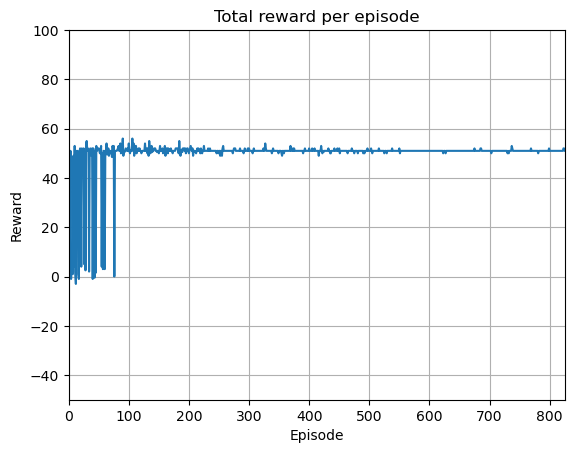

In [11]:
# pre-training

# initial Q-table
print("Initial Q-table")
agent.printQtable()

# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# training
for episode in range(episodes):
    reward = train_t(agent, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward

# trained Q-table
print("Trained Q-table")
agent.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [12]:
# variable to plot the reward dynamic later on
varQD = total_reward

In [13]:
# Save the Qtable of the model as a pickle file

agent.printQtable().to_pickle('Part2.2_Qtable.pickle')

                 Up       Down       Left      Right
State 0   44.155751  46.156440  45.053863  44.368234
State 1   13.732809  46.793252  15.661084  12.504668
State 2    4.243722  11.496128   2.220776  23.430661
State 3    8.321717  37.256580   5.698160   9.981872
State 4   43.375905  47.098408  42.842705  46.869702
State 5   30.002949  48.059389  27.547903  28.770443
State 6    5.286533  47.794904   8.341180  19.263696
State 7   17.335992  48.502003  16.099340  11.654275
State 8   44.289960  44.823024  45.957671  48.059600
State 9   46.633119  47.685195  46.473487  48.020000
State 10  43.739370  48.759138  47.724711  49.000000
State 11  43.939032  50.000000  47.091438  48.361505
State 12  27.258474  18.554673  23.305650  47.614720
State 13  36.107266  41.266160  23.495139  48.995519
State 14  37.487742  30.589564  38.731795  49.999937
State 15   0.000000   0.000000   0.000000   0.000000


In [14]:
# evaluation

episodes = 1
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}

reward = 0
total_reward = np.zeros(episodes)

for episode in range(episodes):
    reward = train_e(agent, environment, steps, -1, False)
    total_reward[episode] = reward

action: moved down
new_state: (1, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
| O=o | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
| O=o | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved right
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |   

In [15]:
# The agent above reaches the goal state very quicky. It also grabs rewards along the way
# Learning rate, 0.15 and discount factor, 0.98 seem to produce an efficient output and agent learns well

### Part - 2.1 Base Model - Agent in a stochastic grid environment trained using Q-learning algorithm

In [16]:
# Doordash delivery agent in a stochastic grid environment

class StochasticGrid:
    
    def __init__(self):
        
        self.observation_space = 16
        self.agent_state = (0,0) # the environment puts the agent here for the first time
        self.old_state_f = 0
        self.new_state_f = 0
        
        # environment
        self.environment = np.zeros((4,4)) 
        self.environment[1, 2] = -1 # police
        self.environment[2, 1] = 1 # free food
        self.environment[3, 0] = 0.5 # free fuel
        self.environment[3, 3] = 50 # home
    
    def reset(self):
        self.environment = np.zeros((4,4))
        self.agent_state = (0,0) 
        self.environment[1, 2] = -1 # police
        self.environment[2, 1] = 1 # free food
        self.environment[3, 0] = 0.5 # free fuel
        self.environment[3, 3] = 50 # home
        self.old_state_f = 0
        self.new_state_f = 0
        
        return self.environment
        
    def step(self, action):
        
        current_state = self.agent_state
        self.old_state_f = (current_state[0]*4) + current_state[1]
        
        terminated = False

        if action == 0:  
            choice = np.random.choice([0,1], p = [0.95,0.05])
            if choice == 0:
                current_state = (current_state[0]-1, current_state[1])  # UP
            else:
                current_state = (current_state[0]+1,current_state[1])  # DOWN
        elif action == 1:  # DOWN
            current_state = (current_state[0]+1,current_state[1])
        elif action == 2:  # LEFT
            current_state = (current_state[0],current_state[1]-1)
        elif action == 3: # RIGHT
            current_state = (current_state[0],current_state[1]+1)
            
        current_state = tuple(np.clip(current_state, 0, 3))
        
        imm_reward = 0
        
        if current_state == (1,2):
            imm_reward = -1  # agent finds the police
        elif current_state == (2, 1):
            imm_reward = 1   # agent gets free food
        elif current_state == (3,0):
            imm_reward = 0.5 # agent gets free fuel
        elif current_state == (3,3):
            terminated = True
            imm_reward = 50  # agent delivers the food
            
        self.new_state_f = (current_state[0]*4) + current_state[1]
        
        self.agent_state = current_state
        # step taken by environment returns the immediate reward, agent_state & meta_data
        return imm_reward, self.agent_state, terminated, self.old_state_f, self.new_state_f
    
    def render(self):
        a = "O=o"  # symbol for the agent, a car!
        s = " "
        print("-------------------------------", end="\n")
        for row in range(4):
            for col in range(4):
                if (row, col) == self.agent_state:
                    print(f"|{a:^{5}}|", end=" ")
                elif self.environment[row, col] == 0:
                    print(f"|{s:^{5}}|", end=" ")
                else:
                    print(f"|{self.environment[row, col]:^{5}}|", end=" ")
            print("\n-------------------------------", end="\n")

In [17]:
# set-up
episodes = 1100
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [ max(1*(0.9954**i),0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)

In [18]:
# create environment
environment = StochasticGrid()
# create agent and place the agent in the evnironment
agent_s = Q_Agent(environment, discount_factor = 0.98, learning_rate = 0.10)

In [19]:
# running the agent in stochastic environment for 10 timesteps
print("Total reward for the episode:", train_e(agent_s, environment, 10, 5, False))

action: moved right
new_state: (0, 1)
reward obtained: 0
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
| 0.5 | |     | |     | |50.0 | 
-------------------------------
action: moved left
new_state: (0, 0)
reward obtained: 0
-------------------------------
| O=o | |     | |     | |     | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
| 0.5 | |     | |     | |50.0 | 
-------------------------------
action: moved right
new_state: (0, 1)
reward obtained: 0
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
| 0.5 | |     | |  

Initial Q-table
           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


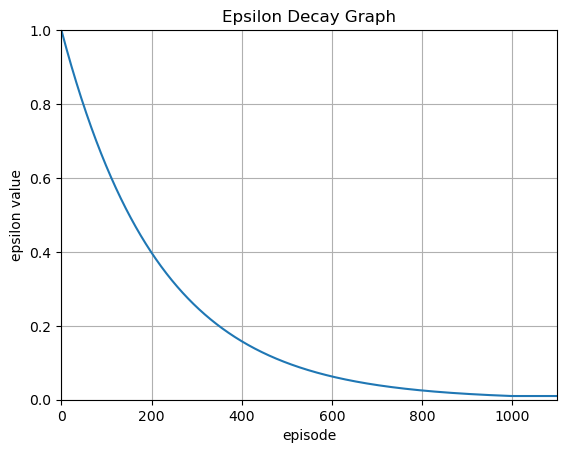

Trained Q-table
                 Up       Down       Left      Right
State 0   45.011321  46.156440  44.747673  45.889010
State 1   33.459706  47.093918  19.752971  20.290687
State 2    6.848534  34.931990   6.386438  14.783998
State 3   11.145761  39.740376   3.904194   0.242767
State 4   44.377920  46.688632  45.921013  47.098408
State 5   45.773097  48.059600  45.703235  45.942758
State 6   18.976423  48.018260  38.474340  32.904539
State 7   22.056581  48.887471  25.941577  34.284983
State 8   28.173925  28.427768  37.172766  48.052835
State 9   46.748213  46.798703  46.559181  48.020000
State 10  46.070133  48.753795  47.787628  49.000000
State 11  47.325405  50.000000  47.483745  48.836289
State 12  22.956141   9.364035  14.607940  42.058142
State 13  29.348247  36.144219  24.188576  48.880624
State 14  44.190267  34.461215  26.317769  49.998805
State 15   0.000000   0.000000   0.000000   0.000000


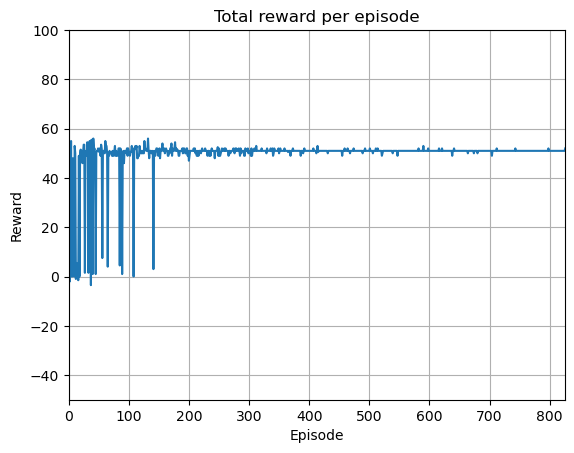

In [20]:
# pre-training

# initial Q-table
print("Initial Q-table")
agent_s.printQtable()

# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# training
for episode in range(episodes):
    reward = train_t(agent_s, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward

# trained Q-table
print("Trained Q-table")
agent_s.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [21]:
# variable to plot the reward dynamic later on
varQS = total_reward

In [22]:
# evaluation

episodes = 1
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}

reward = 0
total_reward = np.zeros(episodes)

for episode in range(episodes):
    reward = train_e(agent_s, environment, steps, -1)
    total_reward[episode] = reward

action: moved down
new_state: (1, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | |     | 
-------------------------------
| O=o | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
| 0.5 | |     | |     | |50.0 | 
-------------------------------
action: moved right
new_state: (1, 1)
reward obtained: 0
-------------------------------
|     | |     | |     | |     | 
-------------------------------
|     | | O=o | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
| 0.5 | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | |     | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
| 0.5 | |     | |   

In [23]:
# The agent in a stochastic environment with discount factor of 0.98 and learning rate of 0.10
# seems to go closer to the optimal policy, it promplty moves towards the rewards and eventually towards the goal

### Hyperparameter Tuning - tweaking discount factor

In [24]:
# Hyperparameter tuning for agent in deterministic environment

# Tuning the discount factor
discount_array = [0.97, 0.99, 1]

In [25]:
environment = DeterministicGrid()
agent_1 = Q_Agent(environment, discount_factor = discount_array[0], learning_rate = 0.10)
agent_2 = Q_Agent(environment, discount_factor = discount_array[1], learning_rate = 0.10)
agent_3 = Q_Agent(environment, discount_factor = discount_array[2], learning_rate = 0.10)

           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


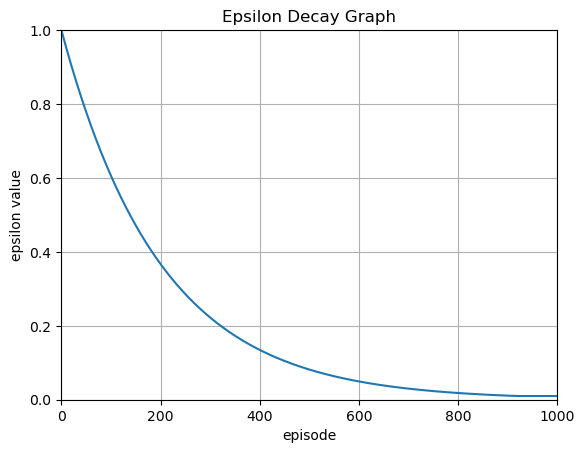

                 Up       Down       Left      Right
State 0   41.326223  43.877601  41.676616  42.659478
State 1   17.069148  45.175674  25.431957  18.344948
State 2    4.760666  38.936631   5.371565   5.047598
State 3    2.868531  19.121889   4.972289   2.465418
State 4   41.505853  44.750071  42.949878  45.234640
State 5   40.932095  46.633650  43.061858  43.778600
State 6   20.658303  47.036018  25.010193  26.753150
State 7    6.274015  40.986157  14.517868  15.247867
State 8   27.253080  30.715606  29.150522  46.617794
State 9   44.388623  46.776937  43.132580  47.045000
State 10  43.842686  48.500000  46.525782  47.599231
State 11  15.761256  49.847837  36.278980  33.891592
State 12  19.055847  24.203972  13.583234  44.659359
State 13  30.920653  40.603907  34.299174  48.498177
State 14  46.665267  48.300646  46.260252  50.000000
State 15   0.000000   0.000000   0.000000   0.000000


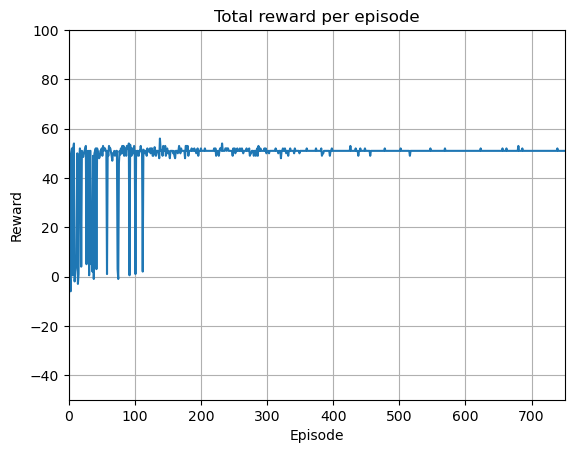

In [26]:
# pre-training

# initial Q-table
agent_1.printQtable()

# training

episodes = 1000
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [max(1*(0.995**i), 0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)


# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

for episode in range(episodes):
    reward = train_t(agent_1, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward
    
# trained Q-table
agent_1.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [27]:
# evaluation

episodes = 1
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}

reward = 0
total_reward = np.zeros(episodes)

for episode in range(episodes):
    reward = train_e(agent_1, environment, steps, -1)
    total_reward[episode] = reward

action: moved down
new_state: (1, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
| O=o | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved right
new_state: (1, 1)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | | O=o | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |   

In [28]:
# With a discount factor of 0.97, the agent performs identical to the base model.
# Infact it takes the same number of steps to reach the goal state

           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


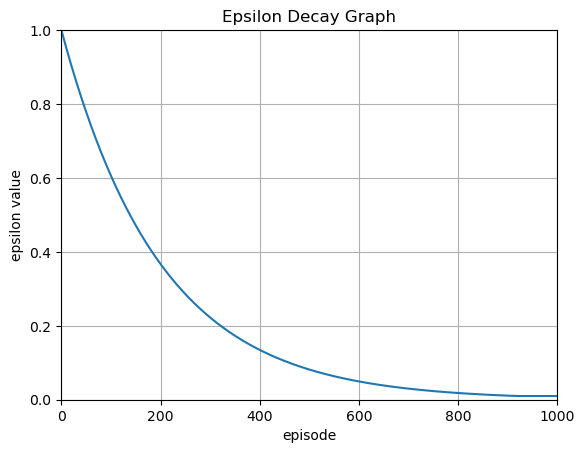

                 Up       Down       Left      Right
State 0   47.307393  48.529602  47.464423  46.575008
State 1   22.899387  48.981502  29.766169  10.855063
State 2    3.957936  36.941372   7.523463  11.303248
State 3    3.249214  24.291125   4.287950   3.579492
State 4   46.857362  47.441405  47.306975  49.019800
State 5   47.168161  49.514950  47.923216  46.511407
State 6   17.083401  48.992280  28.122895  34.971124
State 7   10.256260  46.518115  16.621938  14.809262
State 8   29.398215  27.241294  33.079449  49.468351
State 9   47.762315  48.648572  47.358964  49.005000
State 10  46.719054  49.500000  48.882564  49.068472
State 11  31.460936  49.961322  22.631293  34.732173
State 12  18.174589  11.461984  11.731319  45.069098
State 13  29.874046  40.526964  32.042888  49.498433
State 14  48.572489  49.378663  48.523783  50.000000
State 15   0.000000   0.000000   0.000000   0.000000


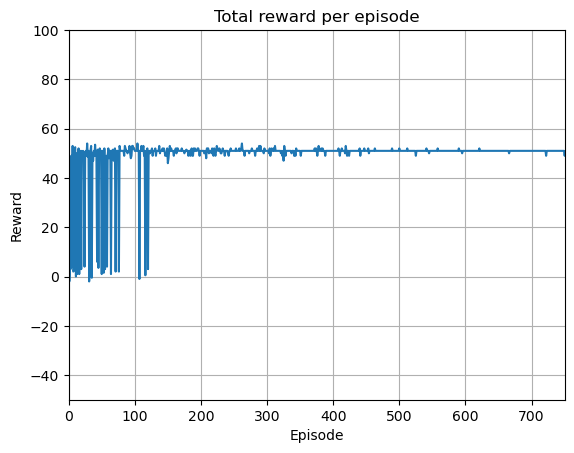

In [29]:
# pre-training

# initial Q-table
agent_2.printQtable()

# training

episodes = 1000
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [max(1*(0.995**i), 0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)


# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

for episode in range(episodes):
    reward = train_t(agent_2, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward
    
# trained Q-table
agent_2.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [30]:
# evaluation

episodes = 1
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}

reward = 0
total_reward = np.zeros(episodes)

for episode in range(episodes):
    reward = train_e(agent_2, environment, steps, -1)
    total_reward[episode] = reward

action: moved down
new_state: (1, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
| O=o | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved right
new_state: (1, 1)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | | O=o | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |   

In [31]:
# With a discount factor of 0.98, the agent performs identical to the base model.
# Infact it takes the same number of steps to reach the goal state
# There isn't much difference between the discount factor being 0.97, 0.98 or 0.99

           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


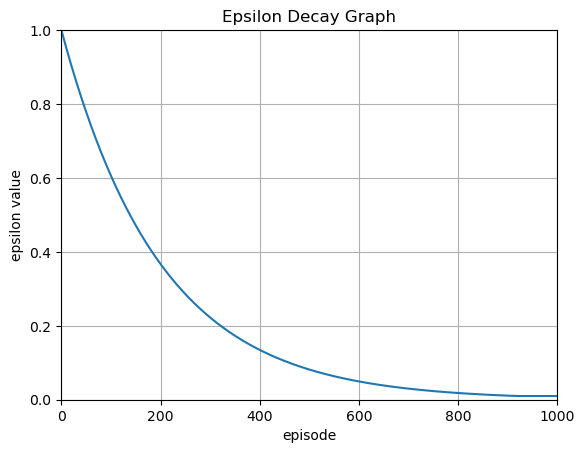

                  Up        Down        Left       Right
State 0    89.604388   51.869595   64.149716  277.730334
State 1    82.925420  282.100512   94.889117   57.432501
State 2    24.938612   15.940041   96.324083    9.022322
State 3     2.340563    3.885414   26.506135    3.411886
State 4    29.288148   97.297249   34.960191   41.863234
State 5    87.697220  286.468577   56.110096   83.992208
State 6    23.534012  209.893333   24.610828   13.980521
State 7     4.258095   11.802714   35.891984    4.369780
State 8    30.327468   38.170698   42.169127  195.694922
State 9   215.271949   49.997378  140.297763  289.496595
State 10  155.951389   50.000000  289.959742  116.684013
State 11   13.269640   28.476640  186.847638   31.208259
State 12   12.258472   27.587742   26.111271   48.999001
State 13   41.436366   39.587031   40.675145   49.999993
State 14   49.308904   49.545092   49.685097   50.000000
State 15    0.000000    0.000000    0.000000    0.000000


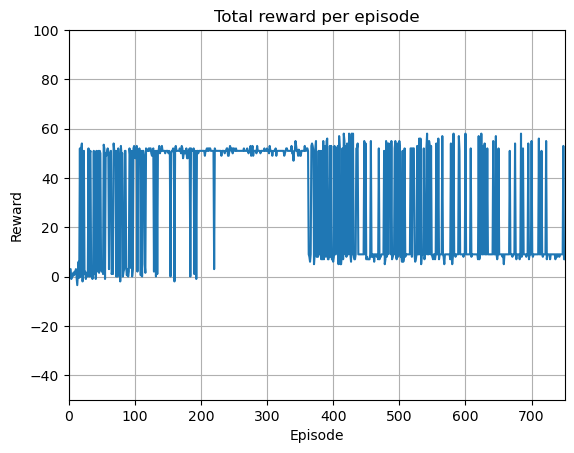

In [32]:
# pre-training

# initial Q-table
agent_3.printQtable()

# training

episodes = 1000
steps = 20
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [max(1*(0.995**i), 0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)


# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

for episode in range(episodes):
    reward = train_t(agent_3, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward
    
# trained Q-table
agent_3.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [33]:
# evaluate
reward = 0
total_reward = np.zeros(1)

for episode in range(1):
    reward = train_e(agent_3, environment, 20, -1)
    total_reward[episode] = reward

action: moved right
new_state: (0, 1)
reward obtained: 0
-------------------------------
|     | | O=o | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (1, 1)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | | O=o | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |   

In [34]:
# With a discount factor of 1, the above agent performs poorly
# The agent is stuck in a loop and is not able to reach the goal even after multiple timesteps
# The rewards per episode is very low indicating that the agent is not learning as training progresses

### Hyperparameter tuning - tweaking the number of episodes

In [35]:
# Hyperparameter tuning for different number of episodes
agent_4 = Q_Agent(environment, discount_factor = 0.99, learning_rate = 0.15)
agent_5 = Q_Agent(environment, discount_factor = 0.99, learning_rate = 0.15)
agent_6 = Q_Agent(environment, discount_factor = 0.99, learning_rate = 0.15)

           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


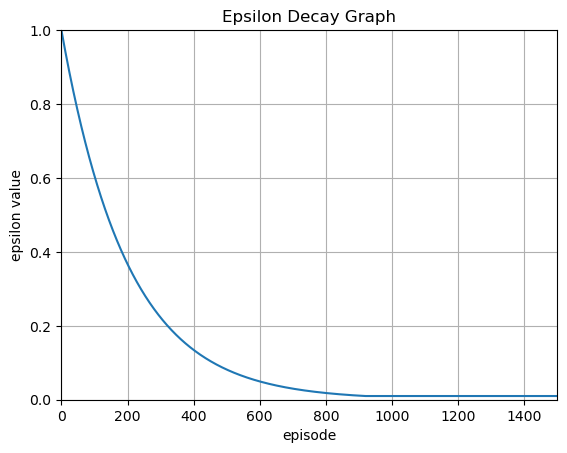

                 Up       Down       Left      Right
State 0   48.027102  48.529602  48.008363  48.428368
State 1   42.781753  49.019713  30.864783  35.228027
State 2   13.453174  44.493971  28.639908  18.904369
State 3   17.079334  37.531607   8.678811  23.184124
State 4   48.037578  48.699802  48.359450  49.019800
State 5   48.487496  49.514950  48.449933  47.491713
State 6   30.887502  49.004993  42.146078  41.870128
State 7   21.003286  48.561013  30.036892  15.814851
State 8   41.033577  37.994057  37.796005  49.514228
State 9   48.961643  48.996496  48.950806  49.005000
State 10  47.507708  49.500000  49.472231  49.459833
State 11  40.528270  49.995970  43.721493  43.689721
State 12  35.103240  23.077923  30.688374  48.256846
State 13  47.750398  45.954440  43.711921  49.499991
State 14  48.981832  49.474135  48.986385  50.000000
State 15   0.000000   0.000000   0.000000   0.000000


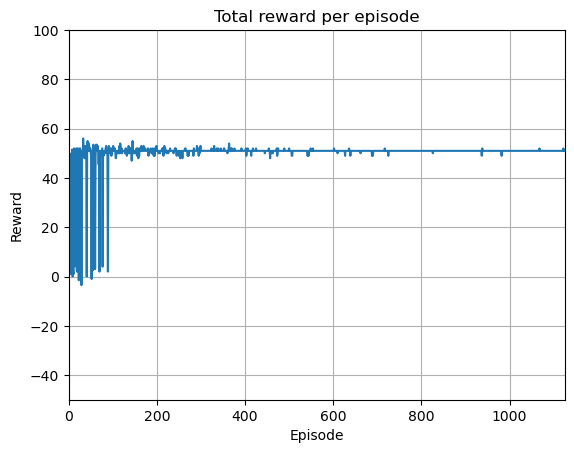

In [36]:
# pre-training

# initial Q-table
agent_4.printQtable()

# training

episodes = 1500
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [max(1*(0.995**i), 0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)


# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

for episode in range(episodes):
    reward = train_t(agent_4, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward
    
# trained Q-table
agent_4.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [37]:
# evaluate
reward = 0
total_reward = np.zeros(1)

for episode in range(1):
    reward = train_e(agent_4, environment, 30, -1)
    total_reward[episode] = reward

action: moved down
new_state: (1, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
| O=o | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved right
new_state: (1, 1)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | | O=o | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |   

In [38]:
# The agent trains runs for about 1500 episodes, but it seems to have negatively effected the performance of the agent
# It is not able to reach the goal and the rewards are also on the lower end

           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


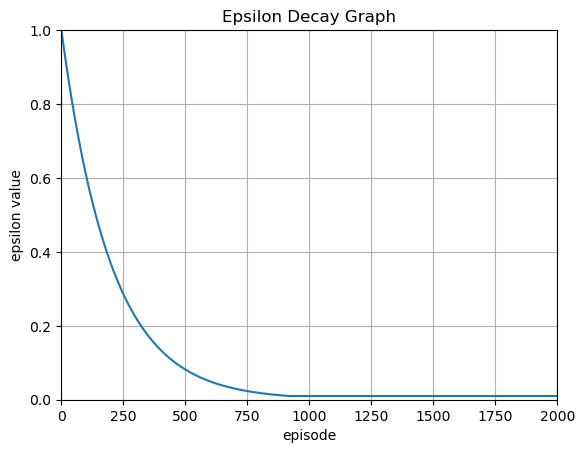

                 Up       Down       Left      Right
State 0   48.554716  48.751575  48.605936  49.251256
State 1   49.002935  49.748744  48.473608  47.001909
State 2   39.015218  47.510662  42.862923  18.146804
State 3    2.733294   1.958372  34.227375   7.683524
State 4   45.199227  49.592660  42.076522  45.722149
State 5   49.015378  50.251256  48.693914  47.298987
State 6   44.550713  49.004923  40.920810  25.888962
State 7    6.097170   7.153130  40.335313  11.720927
State 8   46.768271  44.646495  46.256408  50.251236
State 9   49.748706  49.748744  49.748594  49.005000
State 10  45.022235  49.500000  45.626109  46.389691
State 11  13.636590  49.269093  18.333932  19.132805
State 12  43.133682  42.520239  40.103812  49.748742
State 13  50.251256  49.748721  49.251242  49.500000
State 14  48.974835  49.480059  49.331955  50.000000
State 15   0.000000   0.000000   0.000000   0.000000


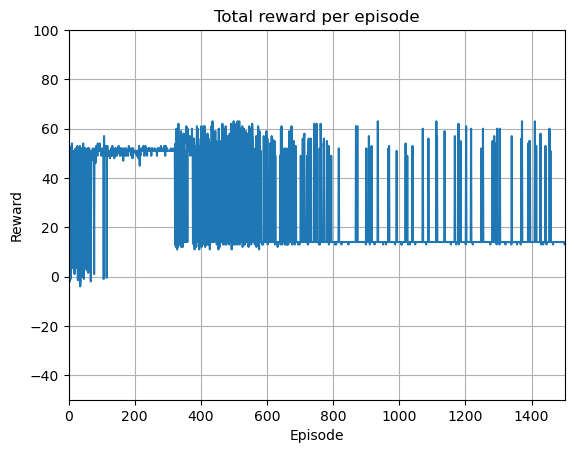

In [39]:
# pre-training

# initial Q-table
agent_5.printQtable()

# training

episodes = 2000
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [max(1*(0.995**i), 0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)


# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

for episode in range(episodes):
    reward = train_t(agent_5, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward
    
# trained Q-table
agent_5.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [40]:
# evaluate
reward = 0
total_reward = np.zeros(1)

for episode in range(1):
    reward = train_e(agent_5, environment, 30, -1)
    total_reward[episode] = reward

action: moved right
new_state: (0, 1)
reward obtained: 0
-------------------------------
|     | | O=o | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (1, 1)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | | O=o | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |   

In [41]:
# In the above scenario, agent runs for 2000 episodes
# The rewards per episode seem to have a smooth transition and eventually increase, which is a good sign of learning

           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


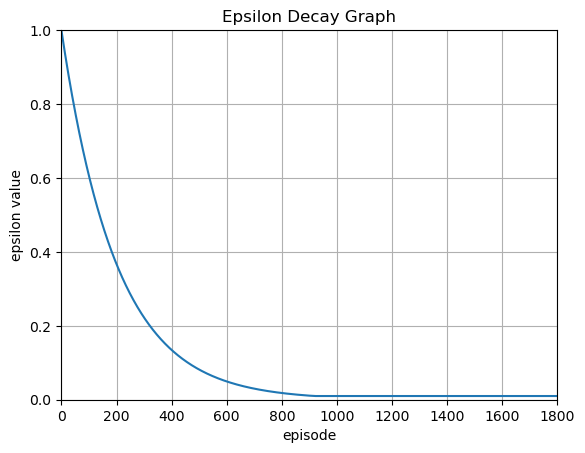

                 Up       Down       Left      Right
State 0   47.961310  48.380220  48.020420  48.529602
State 1   48.246306  49.019800  47.915571  46.947135
State 2   35.101170  47.513005  40.808211  40.703435
State 3   17.881532  48.784652  40.880283  39.209425
State 4   41.097903  32.245033  30.426812  49.018419
State 5   48.228081  49.514950  48.433311  47.514929
State 6   46.272021  48.254586  45.428427  49.005000
State 7   47.918792  49.500000  46.821652  48.842191
State 8   12.752834  15.210071  22.652410  49.207808
State 9   48.988750  48.695895  46.998644  49.005000
State 10  47.272728  49.437640  49.072330  49.500000
State 11  48.971842  50.000000  48.979853  49.468970
State 12   1.436104   2.916921   6.443949  39.180925
State 13  33.154071  42.737885  17.915768  49.467068
State 14  29.884072  37.381951  31.075544  49.999941
State 15   0.000000   0.000000   0.000000   0.000000


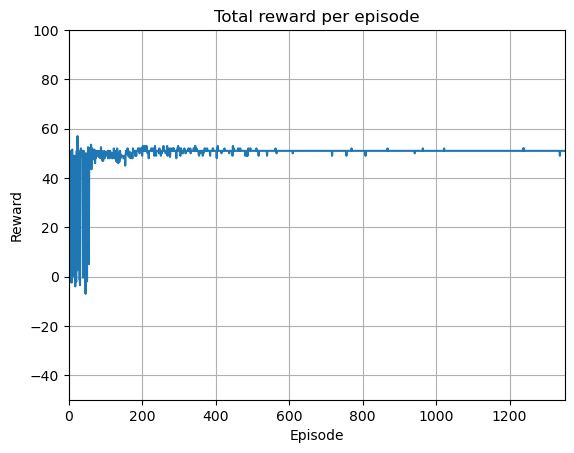

In [42]:
# pre-training

# initial Q-table
agent_6.printQtable()

# training

episodes = 1800
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [max(1*(0.995**i), 0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)


# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

for episode in range(episodes):
    reward = train_t(agent_6, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward
    
# trained Q-table
agent_6.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [43]:
# evaluate
reward = 0
total_reward = np.zeros(1)

for episode in range(1):
    reward = train_e(agent_6, environment, 30, -1)
    total_reward[episode] = reward
    reward = 0

action: moved right
new_state: (0, 1)
reward obtained: 0
-------------------------------
|     | | O=o | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (1, 1)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | | O=o | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |   

In [44]:
# The agent runs for 1800 episodes.
# The rewards per episode also tend to increase during the final phase of training which seems to be a good sign_
# Changing the number of episodes does not seem to have any improvements on the performance of the agent

In [45]:
# It seems that overall the best configuration is the initial configuration of the agent in a deterministic environment 
# It runs for 1000 episodes with learning rate 0.10 and discount factor 0.98 could be the best combination of hyperparameters

### Part 2.2 - SARSA algorithm applied to agent in deterministic grid environment

In [46]:
class SARSA_Agent():
    def __init__(self, environment, learning_rate, discount_factor):
        self.action_space = 4
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.env = environment
        self.Qtable = np.zeros((environment.observation_space, self.action_space))
    
    def step(self, epsilon):
        rand_num = np.random.random()
        if  epsilon != -1 and rand_num < epsilon:
            return np.random.randint(self.action_space) # explore
        else:
            # exploit
            agent_state = self.env.new_state_f
            return np.argmax(self.Qtable[agent_state,:])
        
    def updateQestimates(self, imm_reward, old_state, new_state, action, new_action):
        target = imm_reward + (self.discount_factor*self.Qtable[new_state, new_action])
        self.Qtable[old_state, action] += self.learning_rate*(target - self.Qtable[old_state, action])
        
    def printQtable(self):
        Qdf = pd.DataFrame(self.Qtable)
        Qdf.columns = ["Up", "Down", "Left", "Right"]
        Qdf.index = [f"State {i}" for i in range(16)]
        print(Qdf)
        return Qdf

In [47]:
def train_t(agent, environment, steps, epsilon, flag = True):
    environment.reset()
    reward_history = []
    action = agent.step(epsilon)
    for i in range(steps):
        reward, agent_state, terminated, old_state_f, new_state_f = environment.step(action)
        reward_history.append(reward)
        action_ = agent.step(epsilon)
        if flag:
            agent.updateQestimates(reward, old_state_f, new_state_f, action, action_)
        if terminated: break
        action = action_
    return sum(reward_history)

In [48]:
environment = DeterministicGrid()
SARSAagent = SARSA_Agent(environment, discount_factor=0.98, learning_rate= 0.10)

In [49]:
# train_e() is a slight modification of train_t() 

def train_e(agent, environment, steps, epsilon, flag = True):
    reward_history = []
    environment.reset()
    action = agent.step(epsilon)
    for i in range(steps):
        reward, agent_state, terminated, old_state_f, new_state_f = environment.step(action)
        print("action: moved", action_map[action])
        print("new_state:",agent_state)
        print("reward obtained:", reward)
        reward_history.append(reward)
        environment.render()
        action_ = agent.step(epsilon)
        if flag:
            agent.updateQestimates(reward, old_state_f, new_state_f, action, action_)
        if terminated: break
        action = action_
    return sum(reward_history)

Initial Q-table
           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


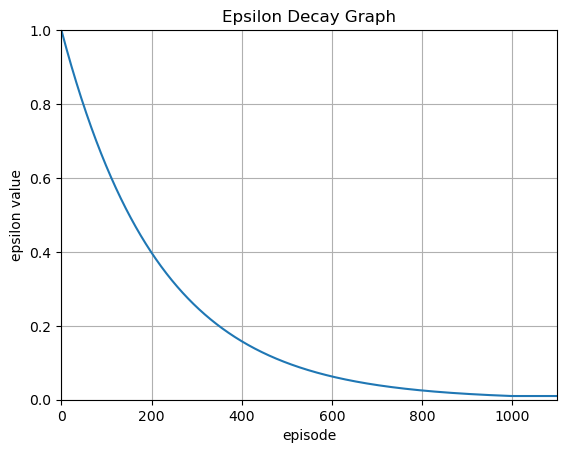

Trained Q-table
                 Up       Down       Left      Right
State 0   24.894233  45.798231  32.961784  33.200217
State 1   10.620239  42.474036   6.889170   3.400080
State 2    1.414821   4.185063   0.635378  15.751966
State 3    5.452562  32.086930   1.366919   3.521375
State 4   31.965700  33.499613  36.103361  46.833421
State 5   28.862683  47.959684  32.346391  35.017627
State 6    4.306685  45.805865   7.960365  21.693904
State 7   10.202849  45.446240  10.082089  13.657319
State 8   10.205838   6.284859   6.224800  44.529707
State 9   35.709261  37.389842  27.976596  48.018724
State 10  34.401198  46.394171  37.041953  48.999844
State 11  35.748202  50.000000  43.609068  46.026319
State 12   3.525300   1.096599   0.410404  20.415140
State 13  12.114613  20.190056   5.390546  45.019760
State 14  24.832743  36.315294  23.083964  49.999779
State 15   0.000000   0.000000   0.000000   0.000000


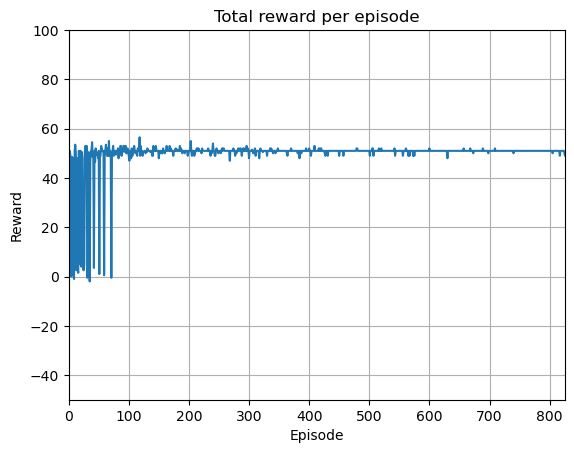

In [50]:
# pre-training
episodes = 1100
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [ max(1*(0.9954**i),0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)

# initial Q-table
print("Initial Q-table")
SARSAagent.printQtable()

# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# training
for episode in range(episodes):
    environment.reset()
    reward = train_t(SARSAagent, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward

# trained Q-table
print("Trained Q-table")
SARSAagent.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [51]:
# variable to plot the reward dynamic later on
varSARSAD = total_reward

In [52]:
# Save the Qtable of the base model as a pickle file
SARSAagent.printQtable().to_pickle('Part2.2_SARSA_Qtable.pickle')

                 Up       Down       Left      Right
State 0   24.894233  45.798231  32.961784  33.200217
State 1   10.620239  42.474036   6.889170   3.400080
State 2    1.414821   4.185063   0.635378  15.751966
State 3    5.452562  32.086930   1.366919   3.521375
State 4   31.965700  33.499613  36.103361  46.833421
State 5   28.862683  47.959684  32.346391  35.017627
State 6    4.306685  45.805865   7.960365  21.693904
State 7   10.202849  45.446240  10.082089  13.657319
State 8   10.205838   6.284859   6.224800  44.529707
State 9   35.709261  37.389842  27.976596  48.018724
State 10  34.401198  46.394171  37.041953  48.999844
State 11  35.748202  50.000000  43.609068  46.026319
State 12   3.525300   1.096599   0.410404  20.415140
State 13  12.114613  20.190056   5.390546  45.019760
State 14  24.832743  36.315294  23.083964  49.999779
State 15   0.000000   0.000000   0.000000   0.000000


In [53]:
# evaluation

episodes = 1
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}

reward = 0
total_reward = np.zeros(episodes)

for episode in range(episodes):
    reward = train_e(SARSAagent, environment, steps, -1, False)
    total_reward[episode] = reward

action: moved down
new_state: (1, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
| O=o | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved right
new_state: (1, 1)
reward obtained: 0
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | | O=o | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
|     | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | | 0.5 | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
|     | |     | |   

### Part 2.2 - SARSA algorithm applied to agent in stochastic grid environment

In [54]:
environment = StochasticGrid()
SARSAagent_s = SARSA_Agent(environment, discount_factor=0.98, learning_rate= 0.10)

Initial Q-table
           Up  Down  Left  Right
State 0   0.0   0.0   0.0    0.0
State 1   0.0   0.0   0.0    0.0
State 2   0.0   0.0   0.0    0.0
State 3   0.0   0.0   0.0    0.0
State 4   0.0   0.0   0.0    0.0
State 5   0.0   0.0   0.0    0.0
State 6   0.0   0.0   0.0    0.0
State 7   0.0   0.0   0.0    0.0
State 8   0.0   0.0   0.0    0.0
State 9   0.0   0.0   0.0    0.0
State 10  0.0   0.0   0.0    0.0
State 11  0.0   0.0   0.0    0.0
State 12  0.0   0.0   0.0    0.0
State 13  0.0   0.0   0.0    0.0
State 14  0.0   0.0   0.0    0.0
State 15  0.0   0.0   0.0    0.0


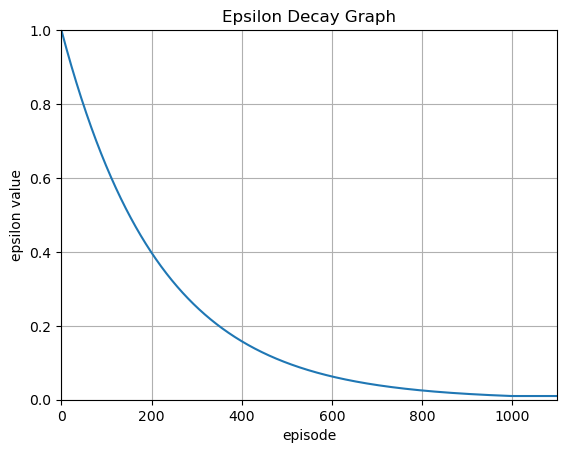

Trained Q-table
                 Up       Down       Left      Right
State 0   36.204665  46.151049  34.630712  29.400550
State 1    7.179355  43.625804   8.185558   4.300500
State 2    1.235808  21.745416   1.552613   0.521811
State 3    0.318379   5.435103  -0.063227   1.004867
State 4   30.238866  32.577099  37.631034  47.096530
State 5   29.884170  48.059104  31.000406  34.090199
State 6    6.620436  45.209413  10.402778  14.871062
State 7    1.272501  33.567588   2.881570   5.492158
State 8   10.468558  12.681301   3.968334  45.359619
State 9   36.434099  42.444782  33.141596  48.019912
State 10  33.378983  48.999992  40.948590  42.927352
State 11  10.747295  49.974624  13.461804  28.424691
State 12   2.422622   6.640578   3.306674  30.677676
State 13  13.063080  23.418656  11.987697  48.508134
State 14  40.276146  45.822401  39.469450  50.000000
State 15   0.000000   0.000000   0.000000   0.000000


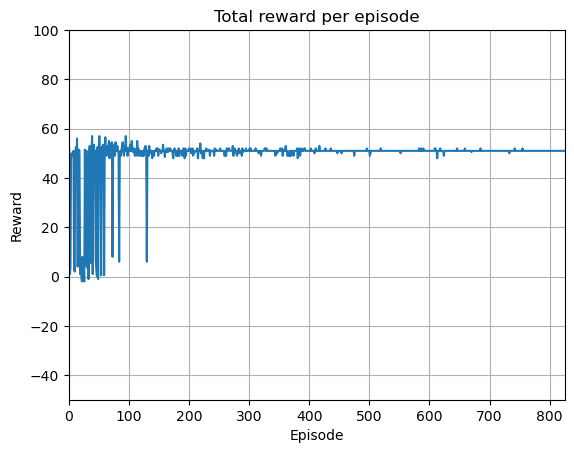

In [55]:
# pre-training
episodes = 1100
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}
epsilon_decay = [ max(1*(0.9954**i),0.01) for i in range(episodes)]
reward = 0
total_reward = np.zeros(episodes)

# initial Q-table
print("Initial Q-table")
SARSAagent_s.printQtable()

# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# training
for episode in range(episodes):
    environment.reset()
    reward = train_t(SARSAagent_s, environment, steps, epsilon_decay[episode])
    total_reward[episode] = reward

# trained Q-table
print("Trained Q-table")
SARSAagent_s.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [56]:
# variable to plot the reward dynamic later on
varSARSAS = total_reward

In [57]:
# evaluation

episodes = 1
steps = 30
action_map = {0: "up", 1:"down", 2: "left", 3: "right"}

reward = 0
total_reward = np.zeros(episodes)

for episode in range(episodes):
    reward = train_e(SARSAagent_s, environment, steps, -1, False)
    total_reward[episode] = reward

action: moved down
new_state: (1, 0)
reward obtained: 0
-------------------------------
|     | |     | |     | |     | 
-------------------------------
| O=o | |     | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
| 0.5 | |     | |     | |50.0 | 
-------------------------------
action: moved right
new_state: (1, 1)
reward obtained: 0
-------------------------------
|     | |     | |     | |     | 
-------------------------------
|     | | O=o | |-1.0 | |     | 
-------------------------------
|     | | 1.0 | |     | |     | 
-------------------------------
| 0.5 | |     | |     | |50.0 | 
-------------------------------
action: moved down
new_state: (2, 1)
reward obtained: 1
-------------------------------
|     | |     | |     | |     | 
-------------------------------
|     | |     | |-1.0 | |     | 
-------------------------------
|     | | O=o | |     | |     | 
-------------------------------
| 0.5 | |     | |   

In [58]:
def reward_dynamic(total_reward, x_label, y_label, title, episodes):
    cumulative_data = [1,2]
    x = [sum(total_reward[0][:i+1]) for i in range(episodes)]
    y = [sum(total_reward[1][:i+1]) for i in range(episodes)]
    plt.figure()
    plt.plot(x, label=x_label, color='blue')
    plt.plot(y, label=y_label, color='red')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative reward')
    plt.xlim(0, episodes)
    plt.ylim(-600, 50000)
    plt.grid()
    plt.legend()
    plt.show()

### Q-learning vs SARSA in Deterministic Environment

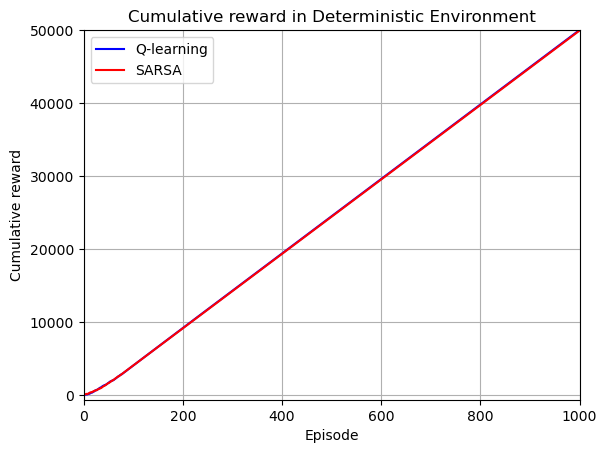

In [59]:
reward_dynamic((varQD, varSARSAD),"Q-learning", "SARSA", "Cumulative reward in Deterministic Environment", 1000)

### Q-learning vs SARSA in Stochastic Environment

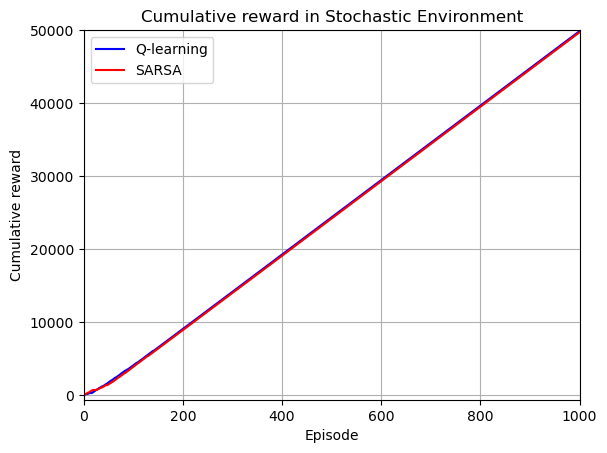

In [60]:
reward_dynamic((varQS, varSARSAS),"Q-learning", "SARSA", "Cumulative reward in Stochastic Environment", 1000)

### Part - 3 Stock Trading Environment

In [61]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [62]:
# Defining an agent that follows the Q-learning algorithm

class Q_Agent:
    
    def __init__(self, environment, learning_rate, discount_factor):
        self.action_space = 3  # buy, sell or hold
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.env = environment
        self.Qtable = np.zeros((4,3))
    
    def step(self, epsilon, observation):
        if  np.random.random() < epsilon and epsilon != -1:
            return np.random.randint(self.action_space) # explore
        else:
            agent_state = observation   # exploit
            return np.argmax(self.Qtable[agent_state,:])
        
    def updateQestimates(self, imm_reward, obs_old, obs_new, action):
        Qmax = max(self.Qtable[obs_new,:])
        self.Qtable[obs_old, action] = self.Qtable[obs_old, action] + self.learning_rate*(imm_reward + (self.discount_factor*Qmax) - self.Qtable[obs_old, action])
        
    def printQtable(self):
        Qdf = pd.DataFrame(self.Qtable)
        Qdf.columns = ["Buy", "Sell", "Hold"]
        Qdf.index = [f"State {i}" for i in range(4)]
        print(Qdf)
        
        return Qdf

In [63]:
def total_reward_per_episode(total_reward, episodes):
    plt.figure()
    plt.plot(total_reward)
    plt.title('Total reward per episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.xlim(0, episodes)
    plt.ylim(-5000, 25000)
    plt.grid()
    plt.show()

In [64]:
def train_t(agent, environment, epsilon):
    reward_history = []
    observation, _ = environment.reset()
    while True:
        action = agent.step(epsilon, observation)
        observation_, reward, terminated, truncated, info = environment.step(action)
        reward_history.append(reward)
        agent.updateQestimates(reward, observation, observation_, action)
        if terminated: break
        observation = observation_
    return sum(reward_history)

In [65]:
def train_e(agent, environment, epsilon):
    reward_history = []
    observation, _ = environment.reset()
    while True:
        action = agent.step(epsilon, observation)
        observation_, reward, terminated, truncated, info = environment.step(action)
        print("action taken:", action_map[action])
        print("reward:", reward)
        print()
        reward_history.append(reward)
        agent.updateQestimates(reward, observation, observation_, action)
        if terminated: break
        observation = observation_
    return sum(reward_history)

In [66]:
# create the environment and the agent

environment = StockTradingEnvironment('./NVDA.csv', True, number_of_days_to_consider=10)
agent = Q_Agent(environment, 0.10, 0.99)

Initial Q-table
         Buy  Sell  Hold
State 0  0.0   0.0   0.0
State 1  0.0   0.0   0.0
State 2  0.0   0.0   0.0
State 3  0.0   0.0   0.0


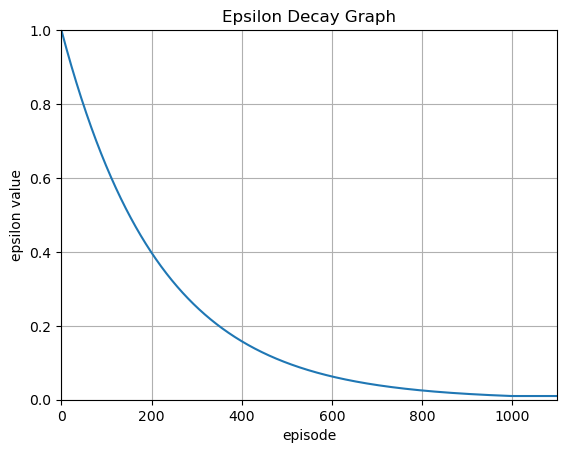

Trained Q-table
                 Buy         Sell         Hold
State 0  1395.864333  1094.742650  1014.816601
State 1  1391.061112  1389.451775  1391.337410
State 2  1376.298023  1033.102538  1041.394777
State 3  1365.013154  1189.360477  1362.300759


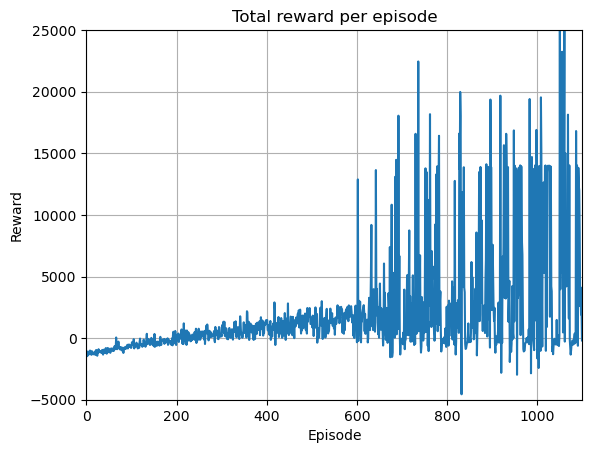

In [67]:
# initial set up
episodes = 1100
epsilon_decay = [ max(1*(0.9954**i),0.01) for i in range(episodes)]
action_map = {0:"Bought", 1:"Sold", 2:"Held"}
total_reward = np.zeros(episodes)
reward = 0

# pre-training

# initial Q-table
print("Initial Q-table")
agent.printQtable()

# Epsilon decay graph
show_epsilon_decay(epsilon_decay, episodes)

# training
for episode in range(episodes):
    reward = train_t(agent, environment, epsilon_decay[episode])
    total_reward[episode] = reward

# trained Q-table
print("Trained Q-table")
agent.printQtable()

# cummulative reward per episode graph
total_reward_per_episode(total_reward, episodes)

In [68]:
# Save the Qtable of the model as a pickle file
agent.printQtable().to_pickle('Part3_Qtable.pickle')

                 Buy         Sell         Hold
State 0  1395.864333  1094.742650  1014.816601
State 1  1391.061112  1389.451775  1391.337410
State 2  1376.298023  1033.102538  1041.394777
State 3  1365.013154  1189.360477  1362.300759


In [69]:
# new stock environment to evaluate the agent
environment_eval = StockTradingEnvironment('./NVDA.csv', False, number_of_days_to_consider=10)

action taken: Bought
reward: 1

action taken: Held
reward: -1.0822734775496419

action taken: Bought
reward: -10

action taken: Bought
reward: -10

action taken: Bought
reward: -10

action taken: Held
reward: -6.0773531341348335

action taken: Held
reward: -5.789753811028777

action taken: Sold
reward: 6.300610523703515

action taken: Bought
reward: 1

action taken: Held
reward: 4.308732450727063

action taken: Held
reward: 4.567911196501917

action taken: Sold
reward: 8.740986403652819

action taken: Bought
reward: 1

action taken: Sold
reward: 0.35985364990355473

action taken: Bought
reward: 1

action taken: Held
reward: 0.1556958727126007

action taken: Held
reward: -5.103366446645043

action taken: Held
reward: 4.290285405325777

action taken: Held
reward: -0.37194100534605723

action taken: Bought
reward: -10

action taken: Held
reward: 2.750627084589331

action taken: Held
reward: 4.774669969944907

action taken: Held
reward: 4.6449285992134905

action taken: Sold
reward: 10.284

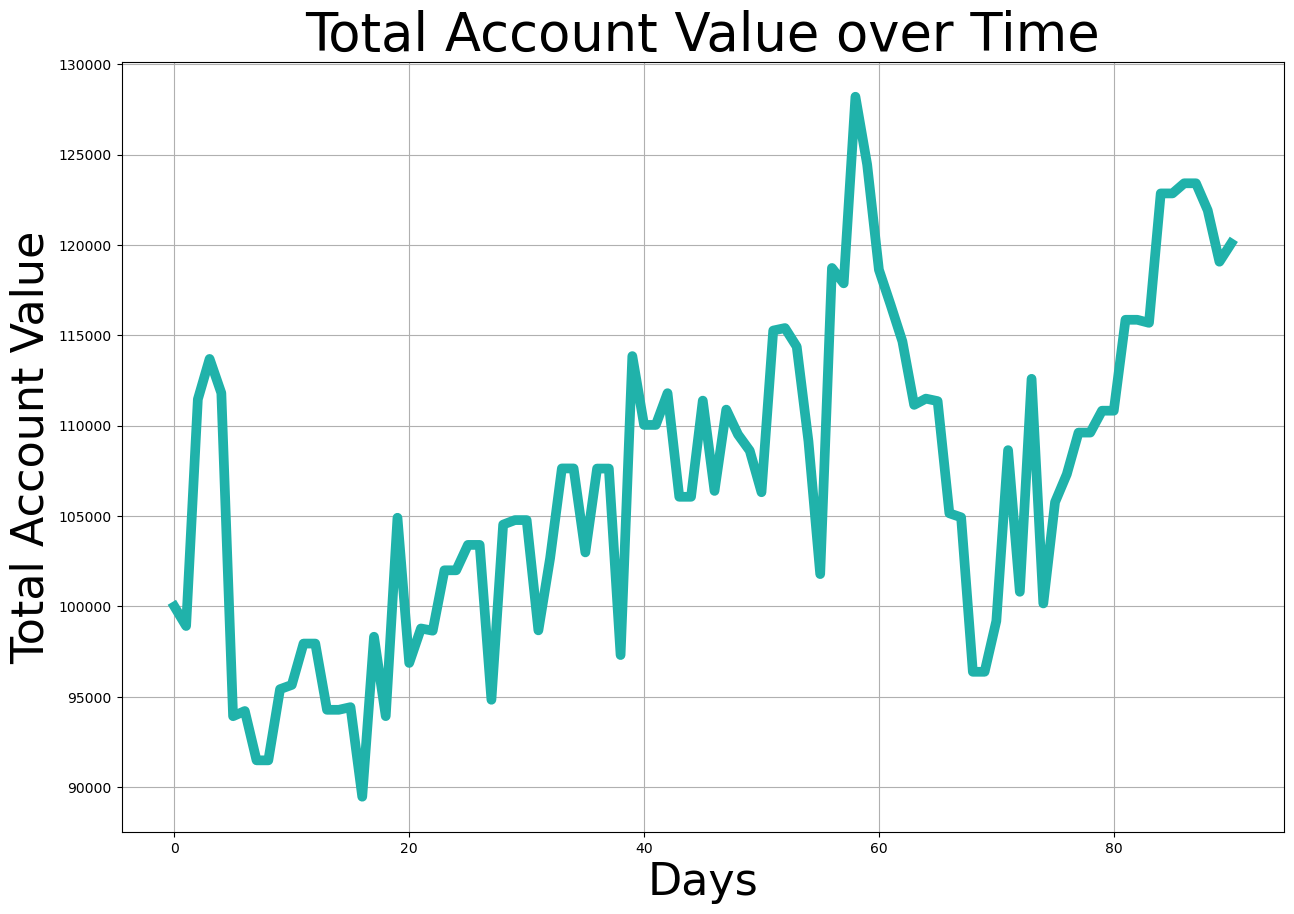

In [70]:
# evaluation

episodes = 1
total_reward = np.zeros(episodes)

for episode in range(episodes):
    total_reward[episode] = train_e(agent, environment_eval, -1)

environment_eval.render()